In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math
from scipy import interpolate
# plt.rc('font',family='Times New Roman',size=15)
import proplot as plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
nx=480
ny=100
L=480e-6
H=100e-6
Tref=773
rhof=4.4908
x_O2=0.22 
hr=3.885e5 #J/mol
Mair=28.88e-3
ladalf=0.055888
DO2=7.63596E-06
theoryCombustionTemp=1.2515


## Estimated the gas production flux due to the coke combustion and the injected air flux 

In [3]:
speciesSurfArea=1e6 # 1/m
A=9.72e6 #m/s
Ta=15767.38032 #K
ConcO2=rhof*x_O2/Mair
Mcoke=25e-3
volumeOfCrossSection=1e-6*H
cokeFrac=0.08

Tc=773
gasProdocutionFlux=speciesSurfArea*A*math.exp(-Ta/Tc)*ConcO2*Mcoke*volumeOfCrossSection*cokeFrac
gasProdocutionFlux

9.210016032899311e-08

In [4]:
Tc=1000
gasProdocutionFlux=speciesSurfArea*A*math.exp(-Ta/Tc)*ConcO2*Mcoke*volumeOfCrossSection*cokeFrac
gasProdocutionFlux

9.444070043664053e-06

In [5]:
Tc=1200
gasProdocutionFlux=speciesSurfArea*A*math.exp(-Ta/Tc)*ConcO2*Mcoke*volumeOfCrossSection*cokeFrac
gasProdocutionFlux

0.0001307495623788758

In [6]:
Pe=0.001
DO2=7.63596e-6
Lc=20e-6
u=Pe*DO2/Lc
phi=rhof*u*H
phi


1.7145784584000003e-07

The gas production rate due to the coke combustion is higher than the air flux by 2 orders of magnitude

## Numerical Combustion Temperature variation with time

## Read DBS

In [7]:
fieldminMaxFile="../DBS/fieldMinMax.dat"
with open(fieldminMaxFile,"r") as fp:
    comment=fp.readline()
    header=fp.readline()
header=header[1:-1].split()
indexs_processor=[]
for i,name in enumerate(header):
    if header[i]=="processor":
        indexs_processor.append(i)
indexs_processor.reverse()  

data=pd.read_csv(fieldminMaxFile,comment='#', sep='\t',header=None)
data=data.drop(indexs_processor,axis=1)
data.rename(columns=lambda x:header[x],inplace=True)
data.head()

,Time,field,min,location(min),max,location(max)
0,0.000001,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
1,0.000003,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
2,0.000004,T,772.9980,(4.350000e-05 4.450000e-05 5.000000e-07),773.0000,(4.445000e-04 4.550000e-05 5.000000e-07)
3,0.000006,T,772.9978,(4.350000e-05 4.450000e-05 5.000000e-07),773.0022,(2.350000e-05 8.450000e-05 5.000000e-07)
4,0.000009,T,772.9976,(6.550000e-05 6.350000e-05 5.000000e-07),773.0077,(2.350000e-05 8.450000e-05 5.000000e-07)


### Read LB

In [8]:
data_lb=pd.read_csv("../LB/combustionTemperatureLB.dat",sep="\t",header=None,names=["Time","Temp"])
data_lb.head()

,Time,Temp
0,0.01,1.073720
1,0.02,1.223787
2,0.03,1.245980
3,0.04,1.230430
4,0.05,1.224149


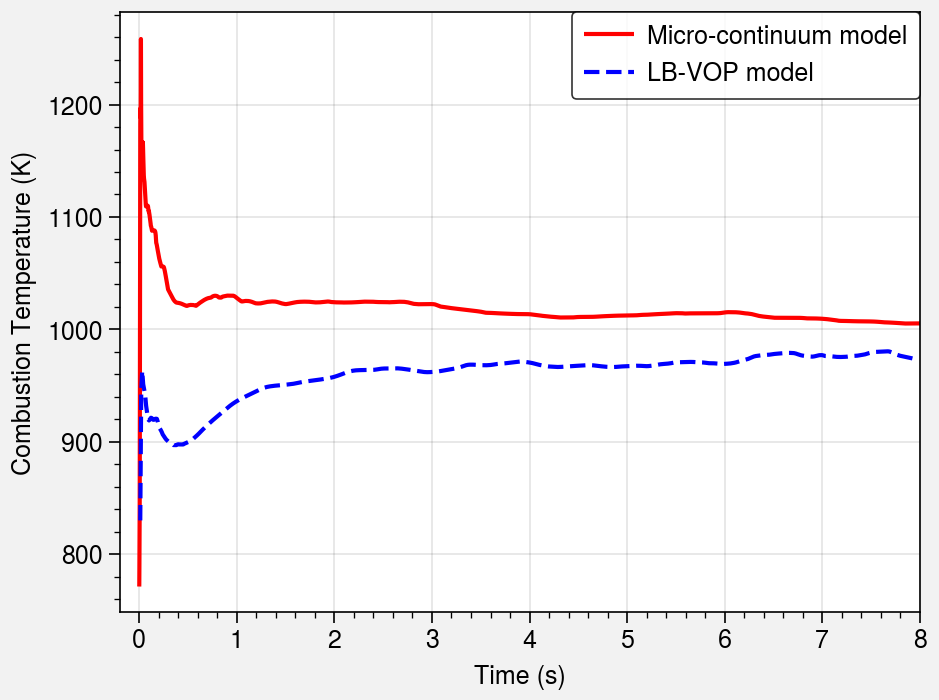

In [9]:
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)
ax.plot(data["Time"],data["max"],lineStyle="-",color="r",label="Micro-continuum model")
ax.plot(data_lb["Time"],data_lb["Temp"]*Tref,lineStyle="--",color="b",label="LB-VOP model")
# ax.plot([np.min(data["Time"]),np.max(data["Time"])],[theoryCombustionTemp,theoryCombustionTemp],lineStyle="-.",color="r",label="Semi-theory by LB")
ax.set_xlim([-0.2,8])
ax.set_xlabel(f"Time (s)")
ax.set_ylabel("Combustion Temperature (K)")
# ax.set_title(f"Combustion Tempereature Evolution")
ax.legend(loc="upper right",ncol=1, fancybox=True)

fig.savefig("comparison of combustion temperature with time.jpg",bbox_inches='tight',dpi=600)

In [10]:
maxCombustionTemp_dbs=np.max(data["max"])/Tref
maxombustionTemp_lb=np.max(data_lb["Temp"])
print(f"max combustion temperature: DBS {maxCombustionTemp_dbs}, LB: {maxombustionTemp_lb}")
print(f"max temperature increase difference: {(maxCombustionTemp_dbs-maxombustionTemp_lb)/(maxCombustionTemp_dbs-1)}")

max combustion temperature: DBS 1.6278990944372573, LB: 1.2684139905853
max temperature increase difference: 0.5725205005656825


In [11]:
meanCombustionTemp_dbs=np.mean(data[data["Time"]>2.0]["max"])/Tref
meanCombustionTemp_lb=np.mean(data_lb[data_lb["Time"]>2.0]["Temp"])
print(f"mean combustion temperature: DBS {meanCombustionTemp_dbs}, LB: {meanCombustionTemp_lb}")
print(f"mean temperature increase difference: {(meanCombustionTemp_dbs-meanCombustionTemp_lb)/(meanCombustionTemp_dbs-1)}")
print(f"coke volume to rock volume ratio: {8.12/(100-42.1-8.12)}")

mean combustion temperature: DBS 1.3070400895245795, LB: 1.254911678174232
mean temperature increase difference: 0.16977721518731667
coke volume to rock volume ratio: 0.16311771795901966


## Combustion Temperature at t=5.0 s

## Read DBS

In [12]:
def readOpenFoamField(file,nx,ny,normizedValue=1):
    with open(file,"r") as fp:
        lines=fp.readlines()
    for i,line in enumerate(lines):
        if line.startswith("internalField"):
            start=i+3
        elif line.startswith("boundaryField"):
            end=i-4
            break
    field=[]
    for i in np.arange(start,end+1):
        value=float(lines[i].replace('\n', ''))
        field.append(value/normizedValue)
    field=np.array(field).reshape(ny,nx)
    return field

In [13]:
temperatureFieldDBS=readOpenFoamField("../../5/T",nx,ny,Tref)

## Read LB

In [14]:
def readLBField(file,nx,ny):
    field=np.fromfile(file,dtype=float)
    field=field.reshape(ny+1,nx+1)
    return field


In [15]:
temperatureFieldLB=readLBField("../LB/500_Temperature",nx,ny)

## Contour Comparison

In [16]:
def showContour(field1,field2,title1,title2,label=""):
    fig,axs=plt.subplots(nrows=2, sharex=True, figsize=(13, 5))
    im=axs[0].imshow(field1,cmap="coolwarm")
    axs[0].axis('off') 
    axs[0].set_title(title1)
    clim=im.properties()['clim']
    axs[1].imshow(field2,cmap="coolwarm",clim=clim)
    axs[1].axis('off') 
    axs[1].set_title(title2)

    fig.colorbar(im,ax=axs.ravel().tolist(),orientation='vertical',shrink=1,label=label)
    return fig, ax

(<Figure size 1300x500 with 3 Axes>,
 SubplotsContainer([CartesianAxesSubplot(0.127521,0.125971;0.851718x0.856192)]))

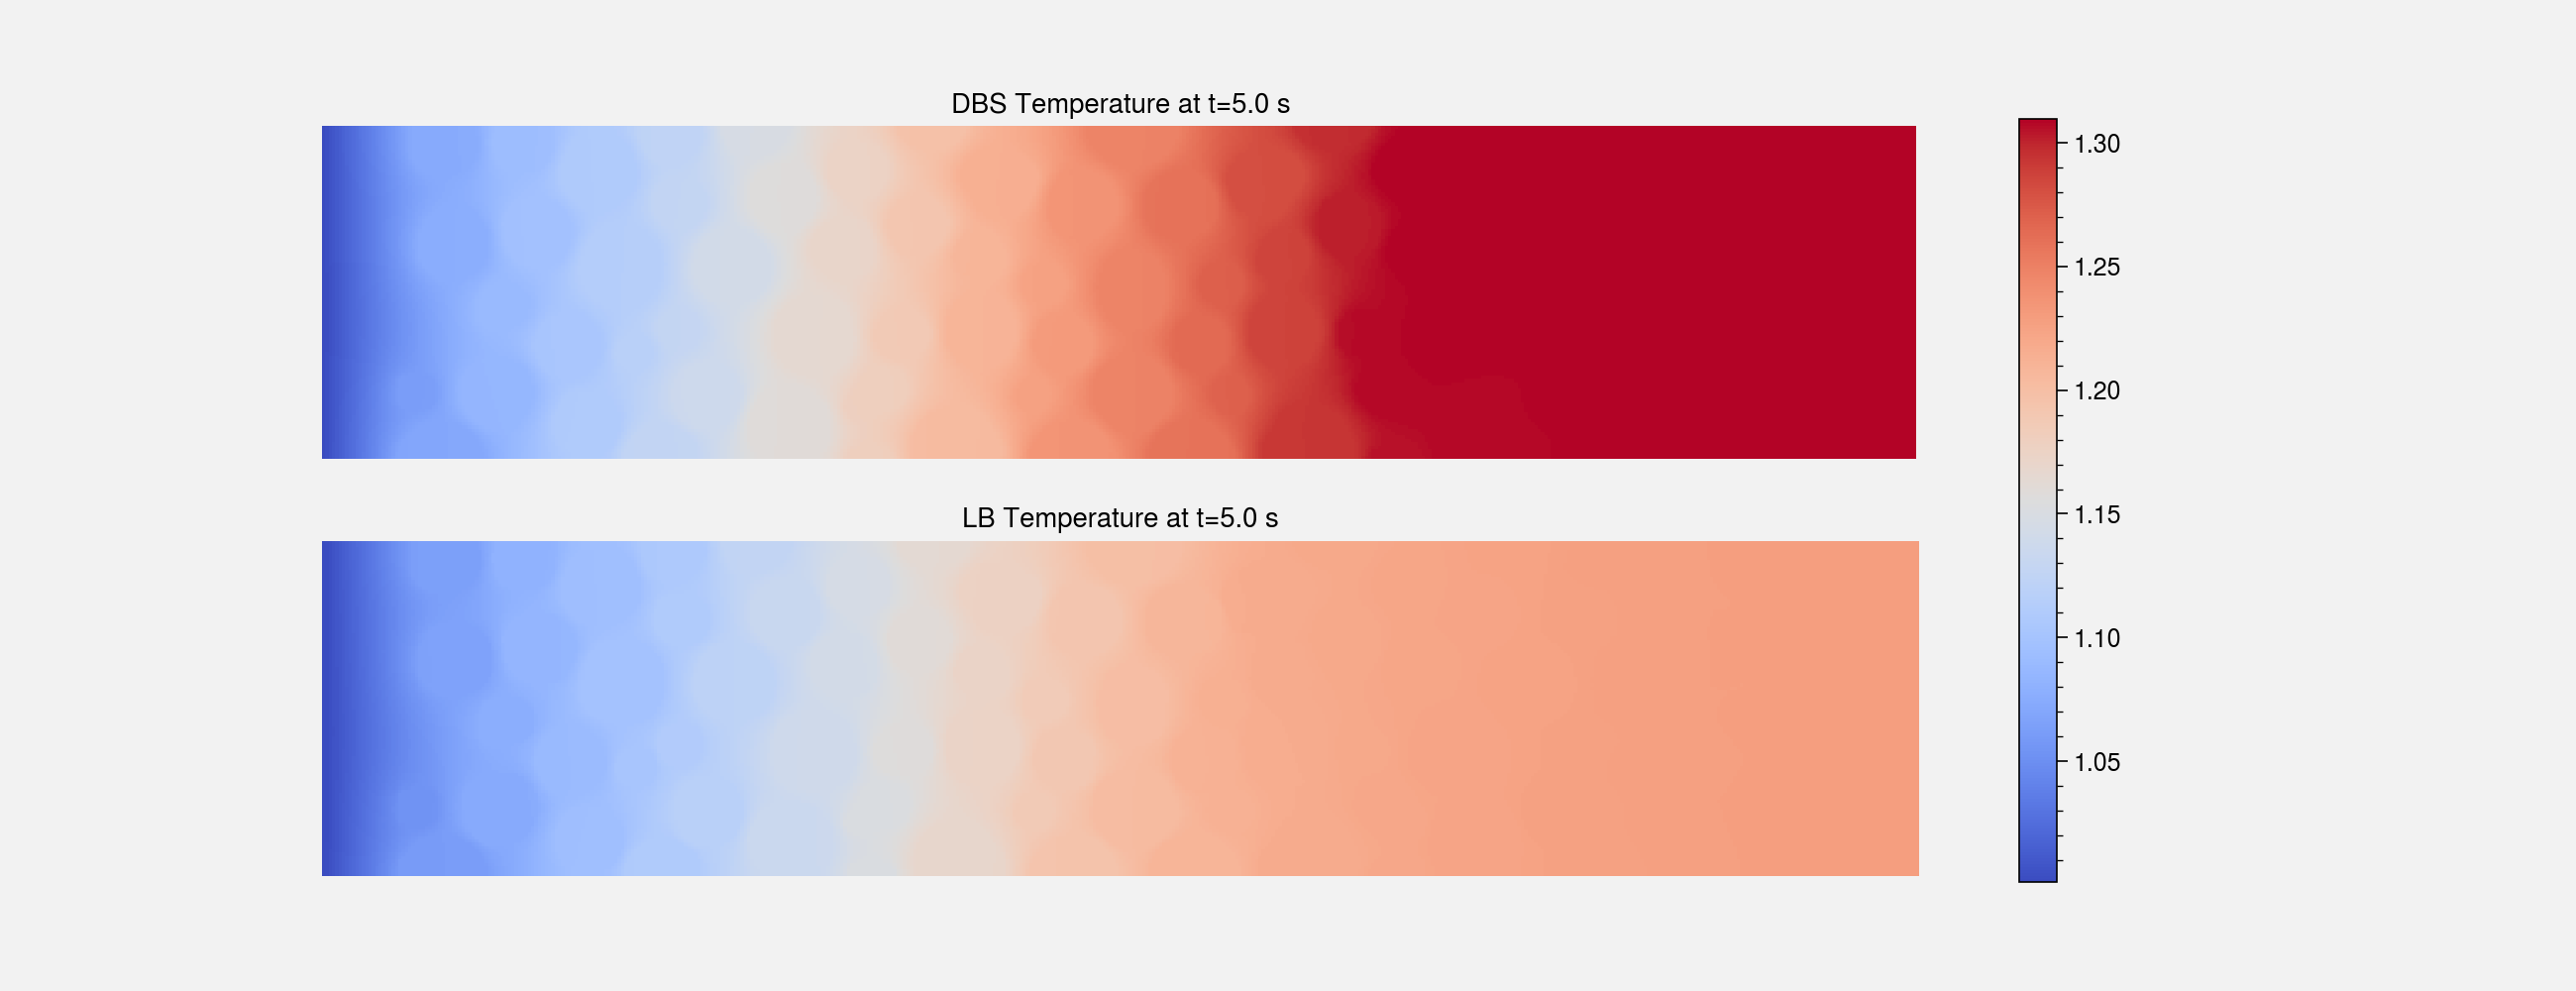

In [17]:
showContour(temperatureFieldDBS,temperatureFieldLB,"DBS Temperature at t=5.0 s","LB Temperature at t=5.0 s")

##  Transversely averaged temperature Comparison

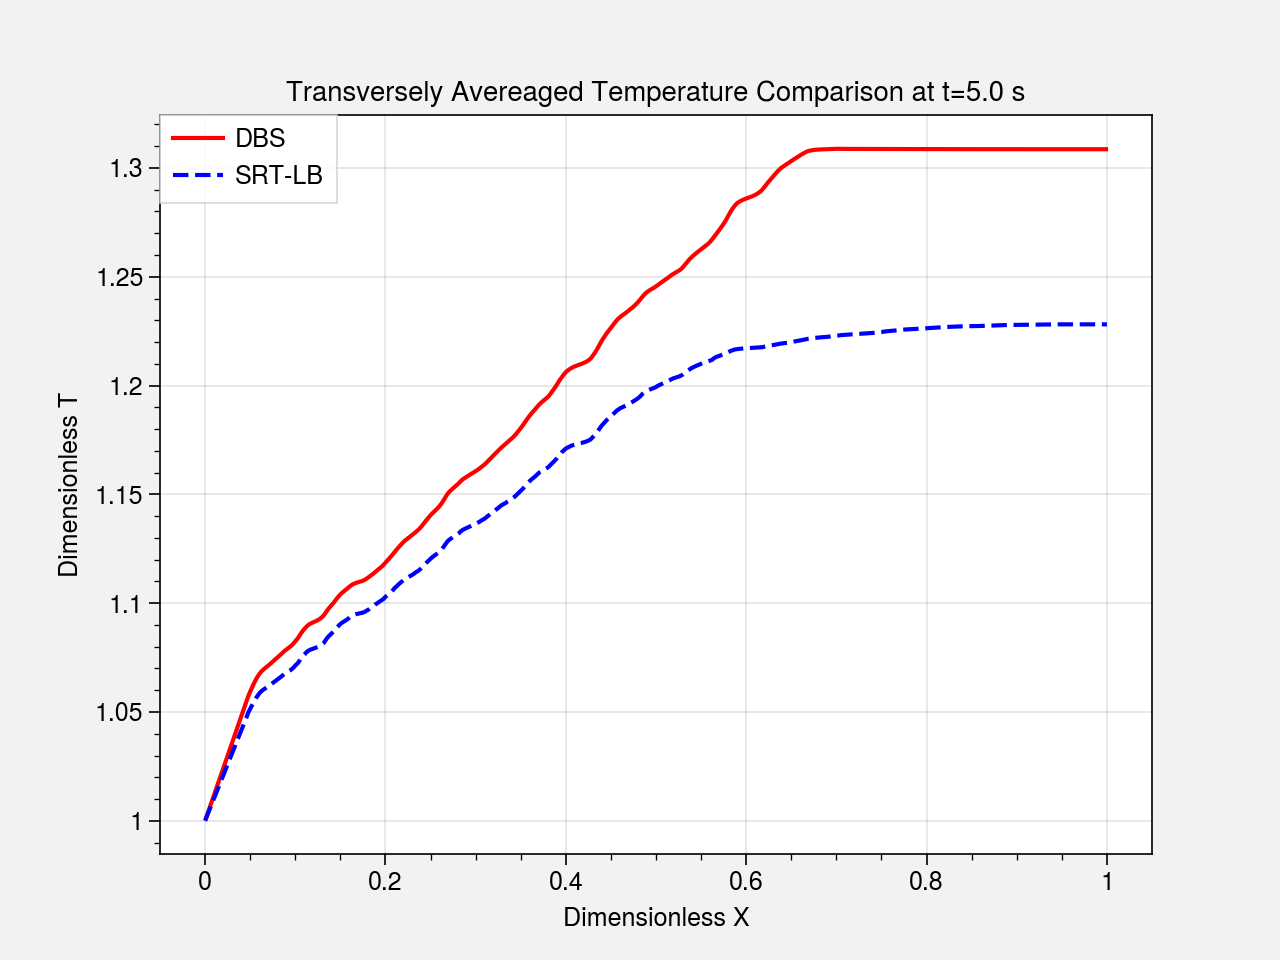

In [18]:
transverseMeanTemperatureLB=np.mean(temperatureFieldLB,axis=0)
xLB=np.arange(0,481)/480
transverseMeanTemperatureDBS=np.mean(temperatureFieldDBS,axis=0)
xDBS=np.arange(0.5,480)/480
fig,ax=plt.subplots()
ax.plot(xDBS,transverseMeanTemperatureDBS,lineStyle="-",color="r",label="DBS")
ax.plot(xLB,transverseMeanTemperatureLB,lineStyle="--",color="b",label="SRT-LB")
ax.set_xlabel("Dimensionless X")
ax.set_ylabel("Dimensionless T")
ax.set_title("Transversely Avereaged Temperature Comparison at t=5.0 s")
ax.legend(loc="upper left")


## Compare O2 Concentration DBS vs LB at t=5.0 s

## Read DBS

In [19]:
O2FieldDBS=readOpenFoamField("../../5/O2",nx,ny)
solidFieldDBS=readOpenFoamField("../../5/solid",nx,ny)

## Read LB

In [20]:
O2FieldLB=np.fromfile(r"../LB/500_Concentration0",dtype=float)
Conct_Reference=1E6/0.02888
O2FieldLB=O2FieldLB.reshape(ny+1,nx+1)/Conct_Reference



## Contour Comparison

(<Figure size 1300x500 with 3 Axes>,
 <AxesSubplot:title={'center':'Transversely Avereaged Temperature Comparison at t=5.0 s'}, xlabel='Dimensionless X', ylabel='Dimensionless T'>)

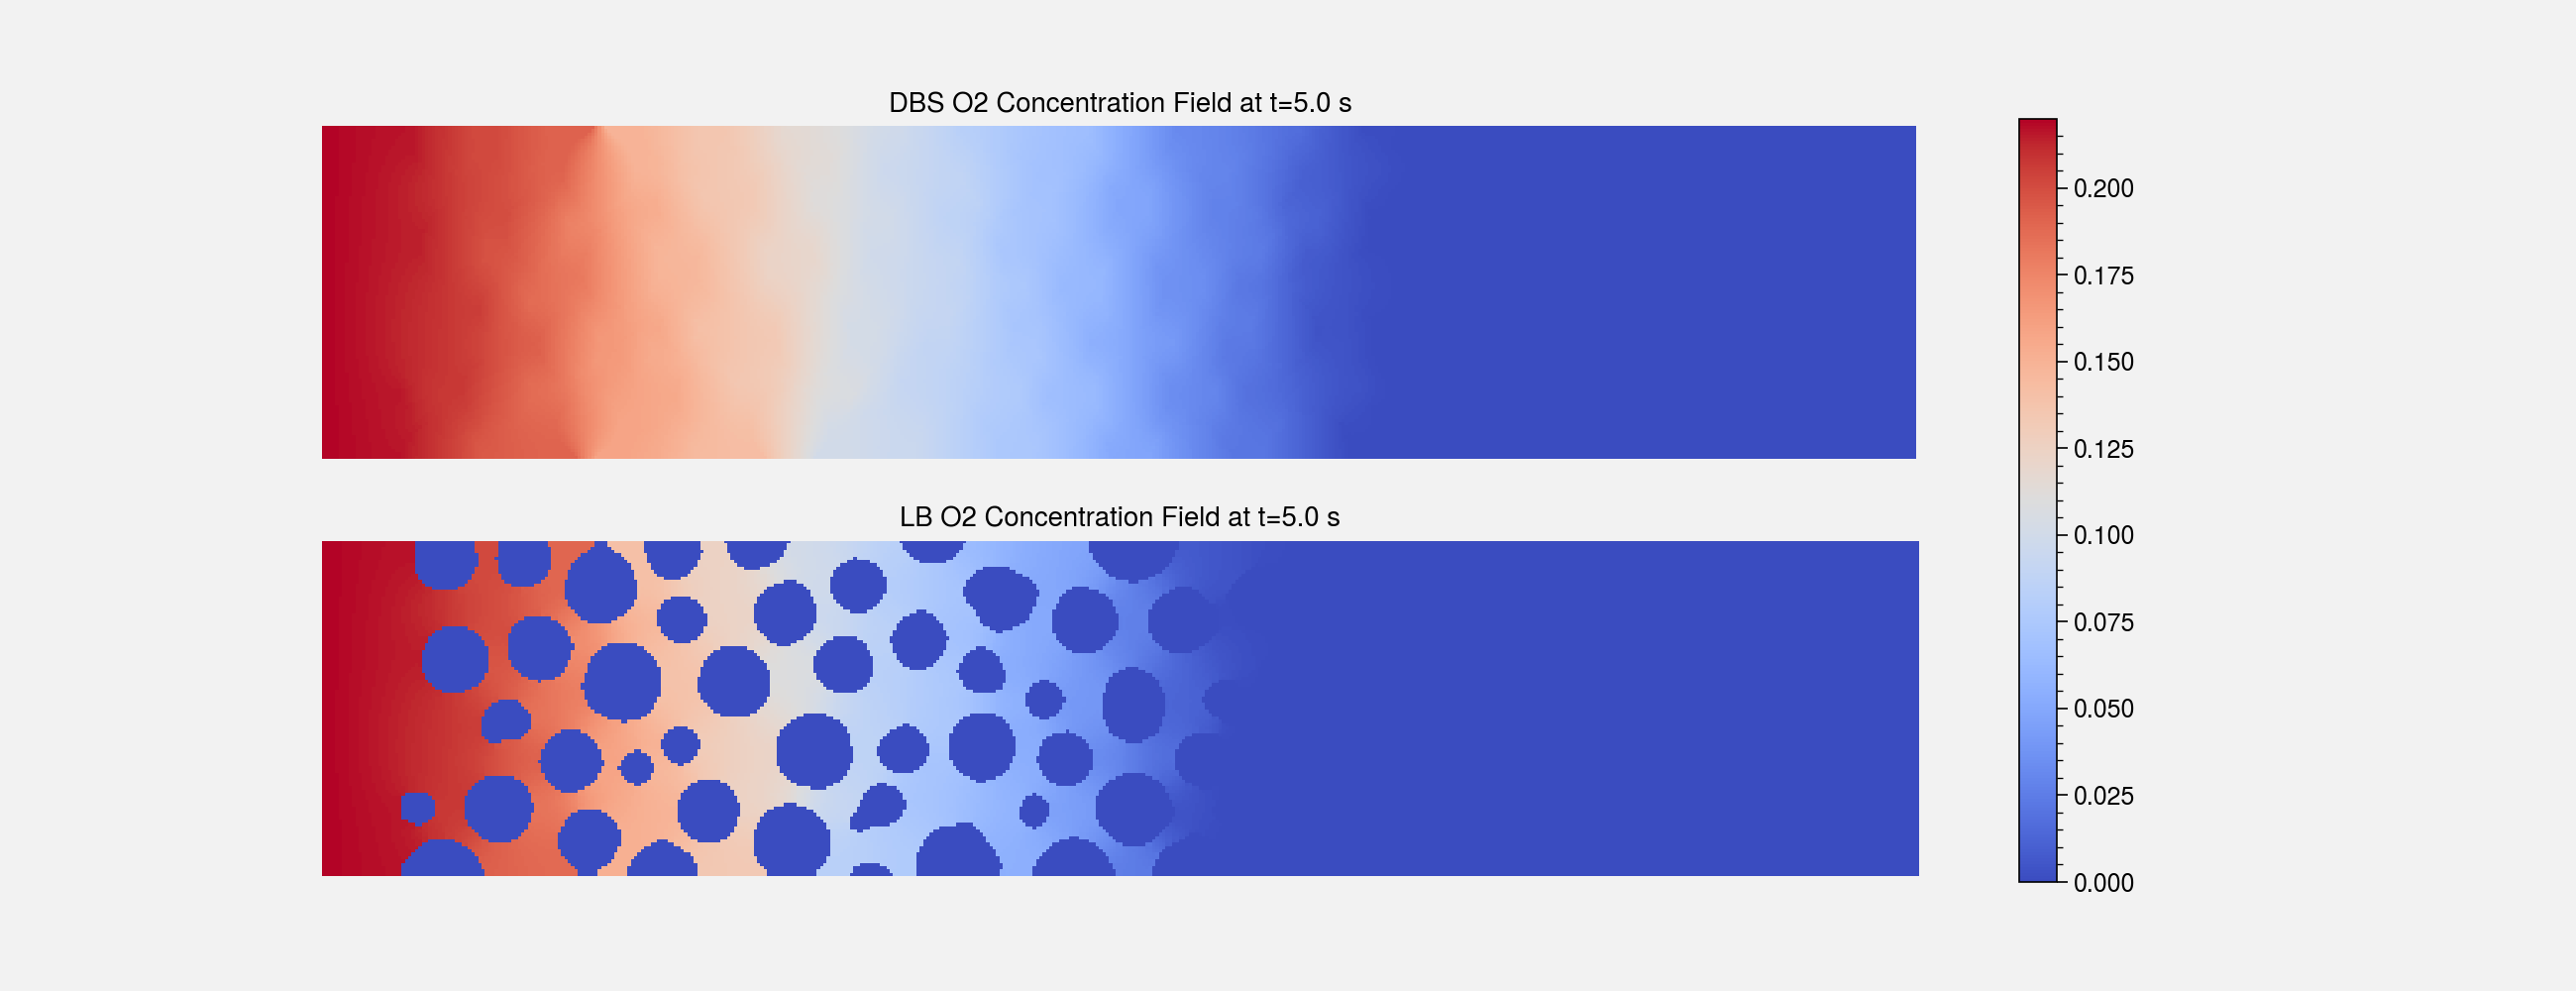

In [21]:
showContour(O2FieldDBS,O2FieldLB,"DBS O2 Concentration Field at t=5.0 s","LB O2 Concentration Field at t=5.0 s")

## Contour Comparison: remove the solid zone of DBS result

(<Figure size 1300x500 with 3 Axes>,
 <AxesSubplot:title={'center':'Transversely Avereaged Temperature Comparison at t=5.0 s'}, xlabel='Dimensionless X', ylabel='Dimensionless T'>)

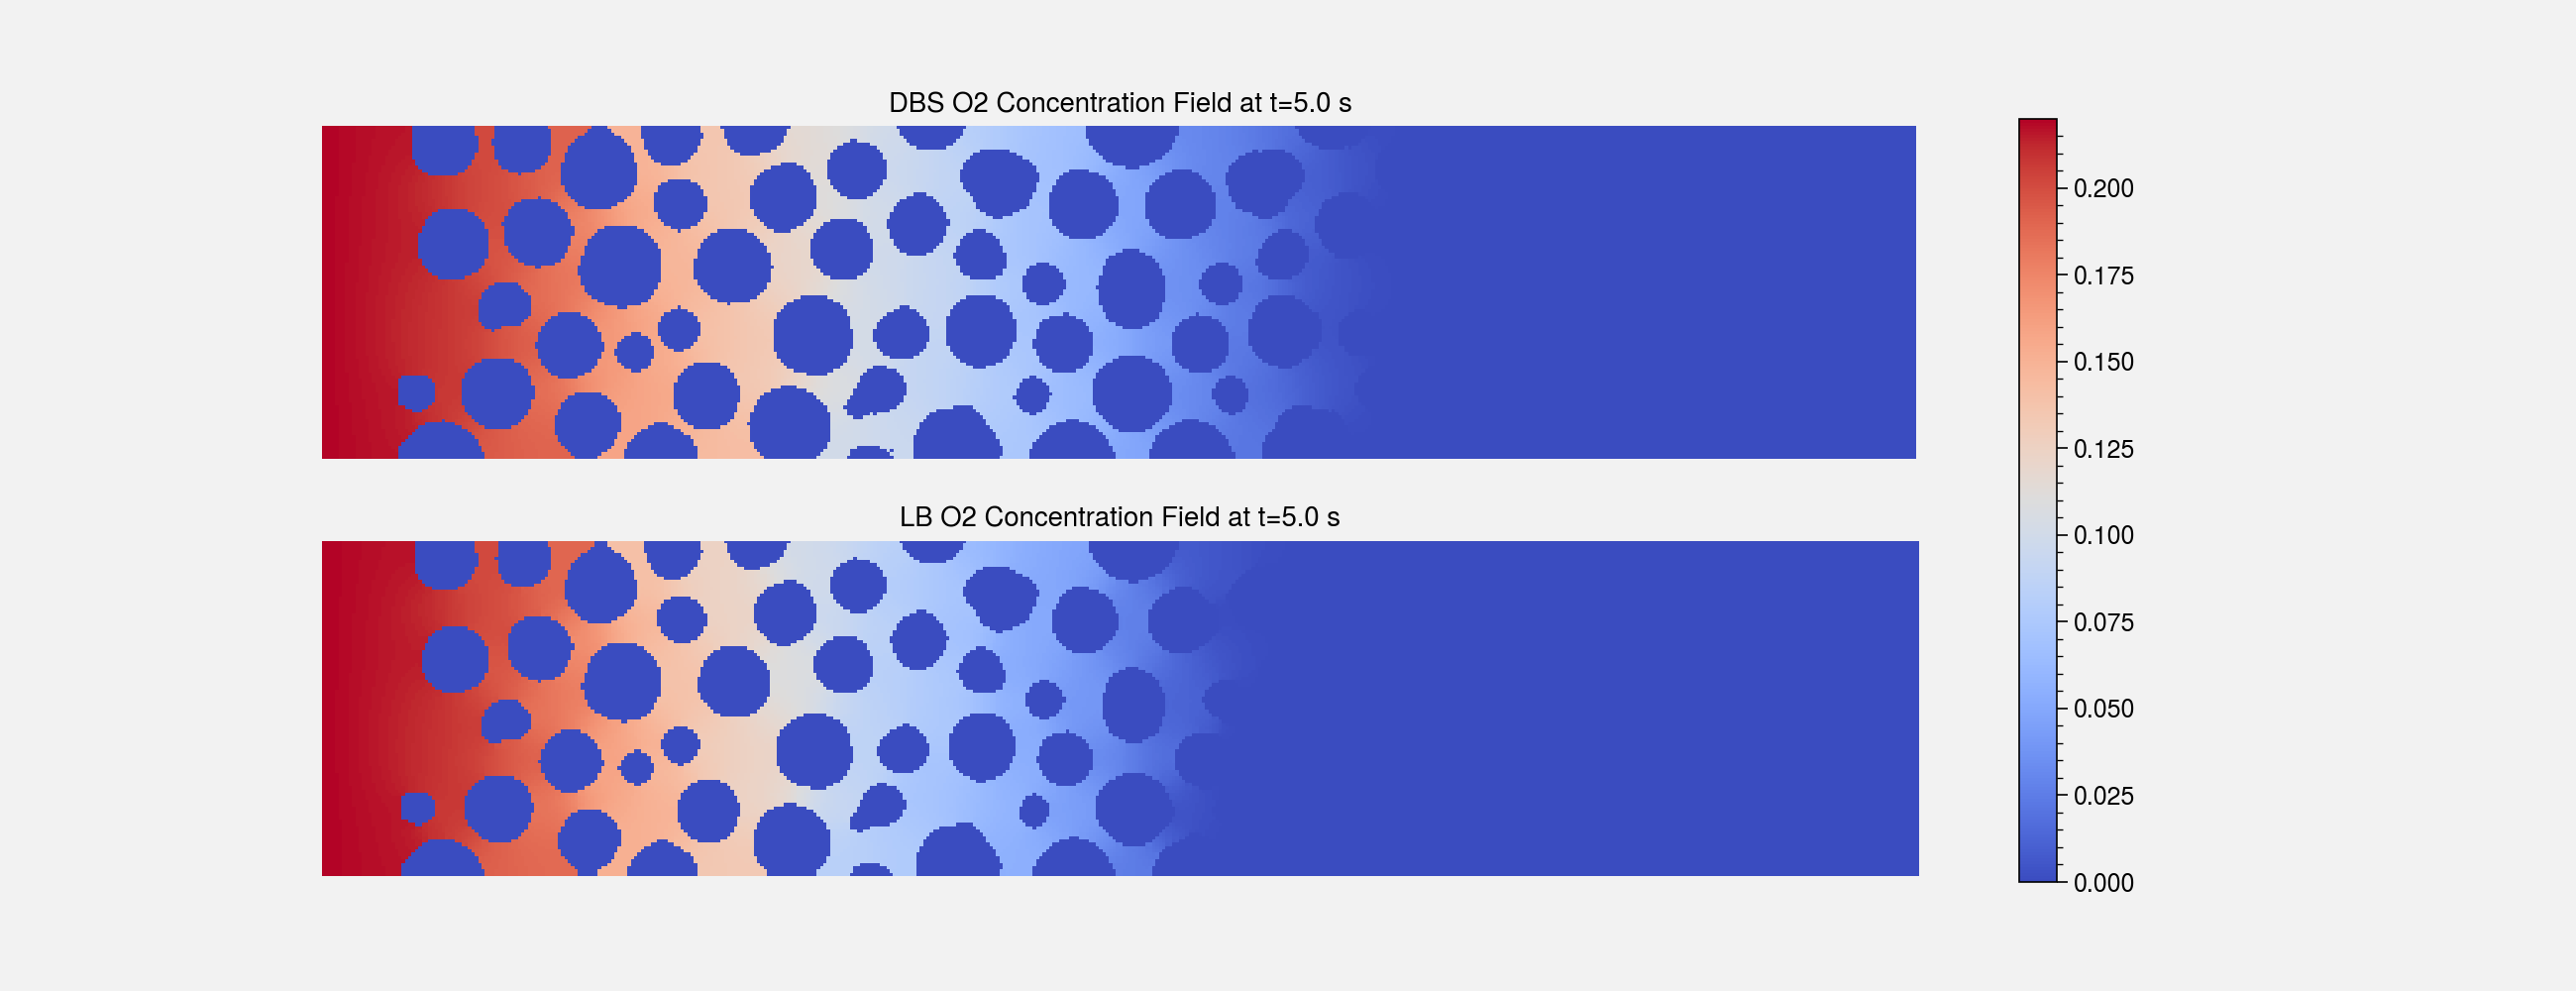

In [22]:
showContour(O2FieldDBS*(1.0-solidFieldDBS),O2FieldLB,"DBS O2 Concentration Field at t=5.0 s","LB O2 Concentration Field at t=5.0 s")

##  Transversely averaged O2 concentration Comparison

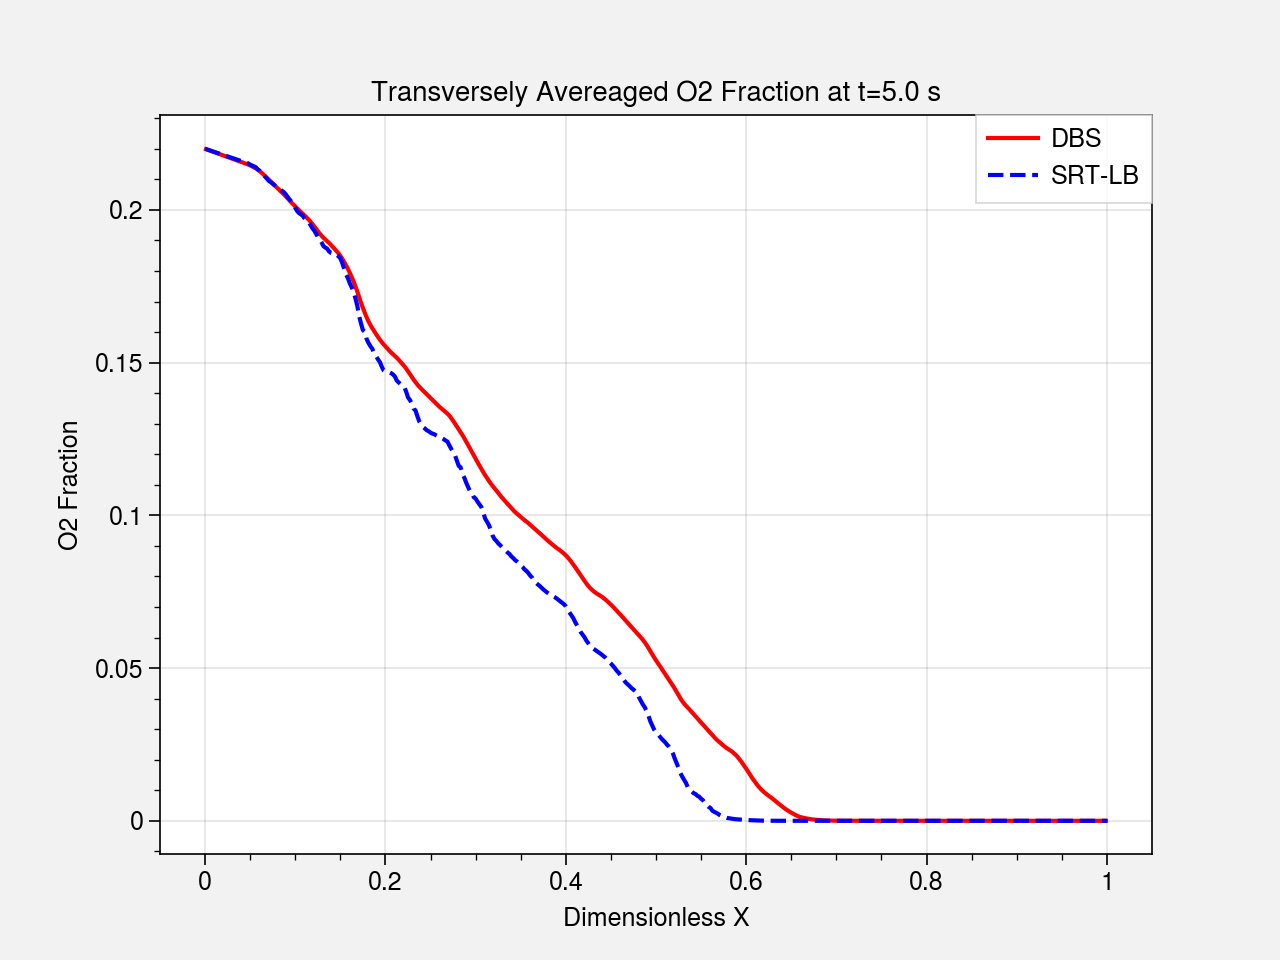

In [23]:
transverseMeanO2ConcLB=np.sum(O2FieldLB,axis=0)/(101-np.sum(O2FieldLB==0,axis=0))
xLB=np.arange(0,481)/480
transverseMeanO2ConcDBS=np.mean(O2FieldDBS,axis=0)
xDBS=np.arange(0.5,480)/480
fig,ax=plt.subplots()
ax.plot(xDBS,transverseMeanO2ConcDBS,lineStyle="-",color="r",label="DBS")
ax.plot(xLB,transverseMeanO2ConcLB,lineStyle="--",color="b",label="SRT-LB")
ax.set_xlabel("Dimensionless X")
ax.set_ylabel("O2 Fraction")
ax.set_title("Transversely Avereaged O2 Fraction at t=5.0 s")
ax.legend(loc="upper right")


## Read MRT Transversely Averaged O2 Frac

In [24]:
temperatureFieldDBS_1s=readOpenFoamField("../../1/T",nx,ny,Tref)
temperatureFieldLB_1s=readLBField("../LB/100_Temperature",nx,ny)
O2FieldDBS_1s=readOpenFoamField("../../1/O2",nx,ny)
solidFieldDBS_1s=readOpenFoamField("../../1/solid",nx,ny)
O2FieldLB_1s=np.fromfile(r"../LB/100_Concentration0",dtype=float)
Conct_Reference=1E6/0.02888
O2FieldLB_1s=O2FieldLB_1s.reshape(ny+1,nx+1)/Conct_Reference

In [25]:
transverseMeanO2ConcMRTLB_1s=pd.read_csv("../LB/MRT_Transv_O2_1s.dat",sep="\\s+",header=None,names=["X","O2"])
transverseMeanO2ConcMRTLB_1s.sort_values("X",inplace=True)
transverseMeanO2ConcMRTLB_1s.reset_index(drop=True,inplace=True)
transverseMeanO2ConcMRTLB_1s.head()

,X,O2
0,0.004819,0.219393
1,0.015306,0.215528
2,0.029762,0.212008
3,0.043084,0.208282
4,0.053288,0.204072


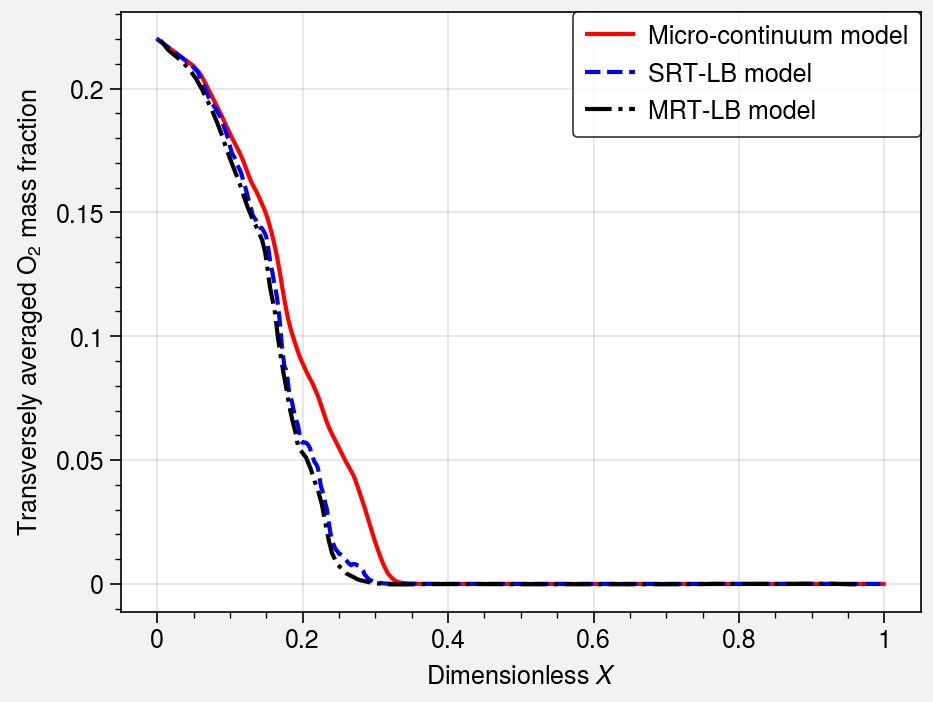

In [26]:
transverseMeanO2ConcLB_1s=np.sum(O2FieldLB_1s,axis=0)/(101-np.sum(O2FieldLB_1s==0,axis=0))
xLB=np.arange(0,481)/480
transverseMeanO2ConcDBS_1s=np.mean(O2FieldDBS_1s,axis=0)
xDBS=np.arange(0.5,480)/480
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)
ax.plot(xDBS,transverseMeanO2ConcDBS_1s,lineStyle="-",color="r",label="Micro-continuum model")
ax.plot(xLB,transverseMeanO2ConcLB_1s,lineStyle="--",color="b",label="SRT-LB model")
ax.plot(transverseMeanO2ConcMRTLB_1s["X"],transverseMeanO2ConcMRTLB_1s["O2"],lineStyle="-.",color="k",label="MRT-LB model")
ax.set_xlabel("Dimensionless $\mathit{X}$")
ax.set_ylabel("Transversely averaged $O_{2}$ mass fraction")
# ax.set_title("Transversely Avereaged O2 Fraction at t=1.0 s")
ax.legend(loc="upper right",ncol=1, fancybox=True)

fig.savefig("comparison of O2 fraction at 1s.jpg",bbox_inches='tight',dpi=600)


## Read MRT Transversely Averaged Tempature

In [27]:
transverseMeanTemperatureMRTLB_1s=pd.read_csv("../LB/MRT_Transv_Temperature_1s.dat",sep="\\s+",header=None,names=["X","Temp"])
transverseMeanTemperatureMRTLB_1s.sort_values("X",inplace=True)
transverseMeanTemperatureMRTLB_1s.reset_index(drop=True,inplace=True)
transverseMeanTemperatureMRTLB_1s.head()

,X,Temp
0,0.000000,0.999231
1,0.028133,1.040022
2,0.038363,1.059260
3,0.058255,1.078592
4,0.069054,1.083814


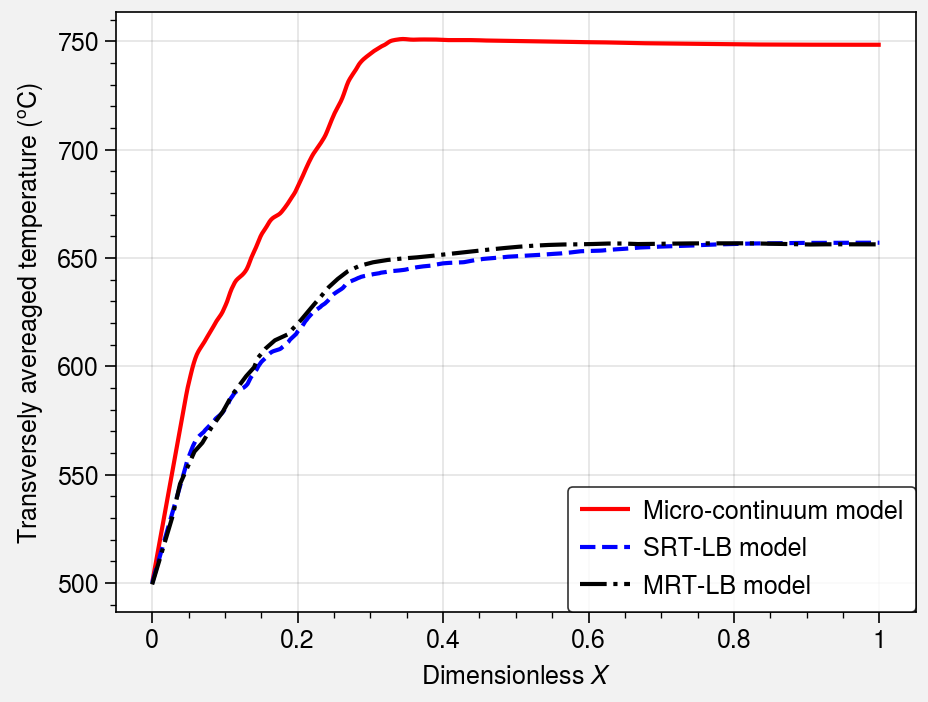

In [28]:
transverseMeanTemperatureLB_1s=np.mean(temperatureFieldLB_1s,axis=0)
xLB=np.arange(0,481)/480
transverseMeanTemperatureDBS_1s=np.mean(temperatureFieldDBS_1s,axis=0)
xDBS=np.arange(0.5,480)/480
fig, ax = plot.subplots( aspect=(4, 3), axwidth=4)
ax.plot(xDBS,transverseMeanTemperatureDBS_1s*Tref-273.15,lineStyle="-",color="r",label="Micro-continuum model")
ax.plot(xLB,transverseMeanTemperatureLB_1s*Tref-273.15,lineStyle="--",color="b",label="SRT-LB model")
ax.plot(transverseMeanTemperatureMRTLB_1s["X"],transverseMeanTemperatureMRTLB_1s["Temp"]*Tref-273.15,color="k",lineStyle="-.",label="MRT-LB model")
ax.set_xlabel("Dimensionless $\mathit{X}$")
ax.set_ylabel("Transversely avereaged temperature ($^{o}C$)")
# ax.set_title("Transversely Avereaged Temperature Comparison at t=1.0 s")
ax.legend(loc="lower right",ncol=1, fancybox=True)

fig.savefig("comparison of temperature at 1s.jpg",bbox_inches='tight',dpi=600)


## Combustion Temperature at t=1.0 s

In [29]:
plt.rc('font',family='Times New Roman',size=15)

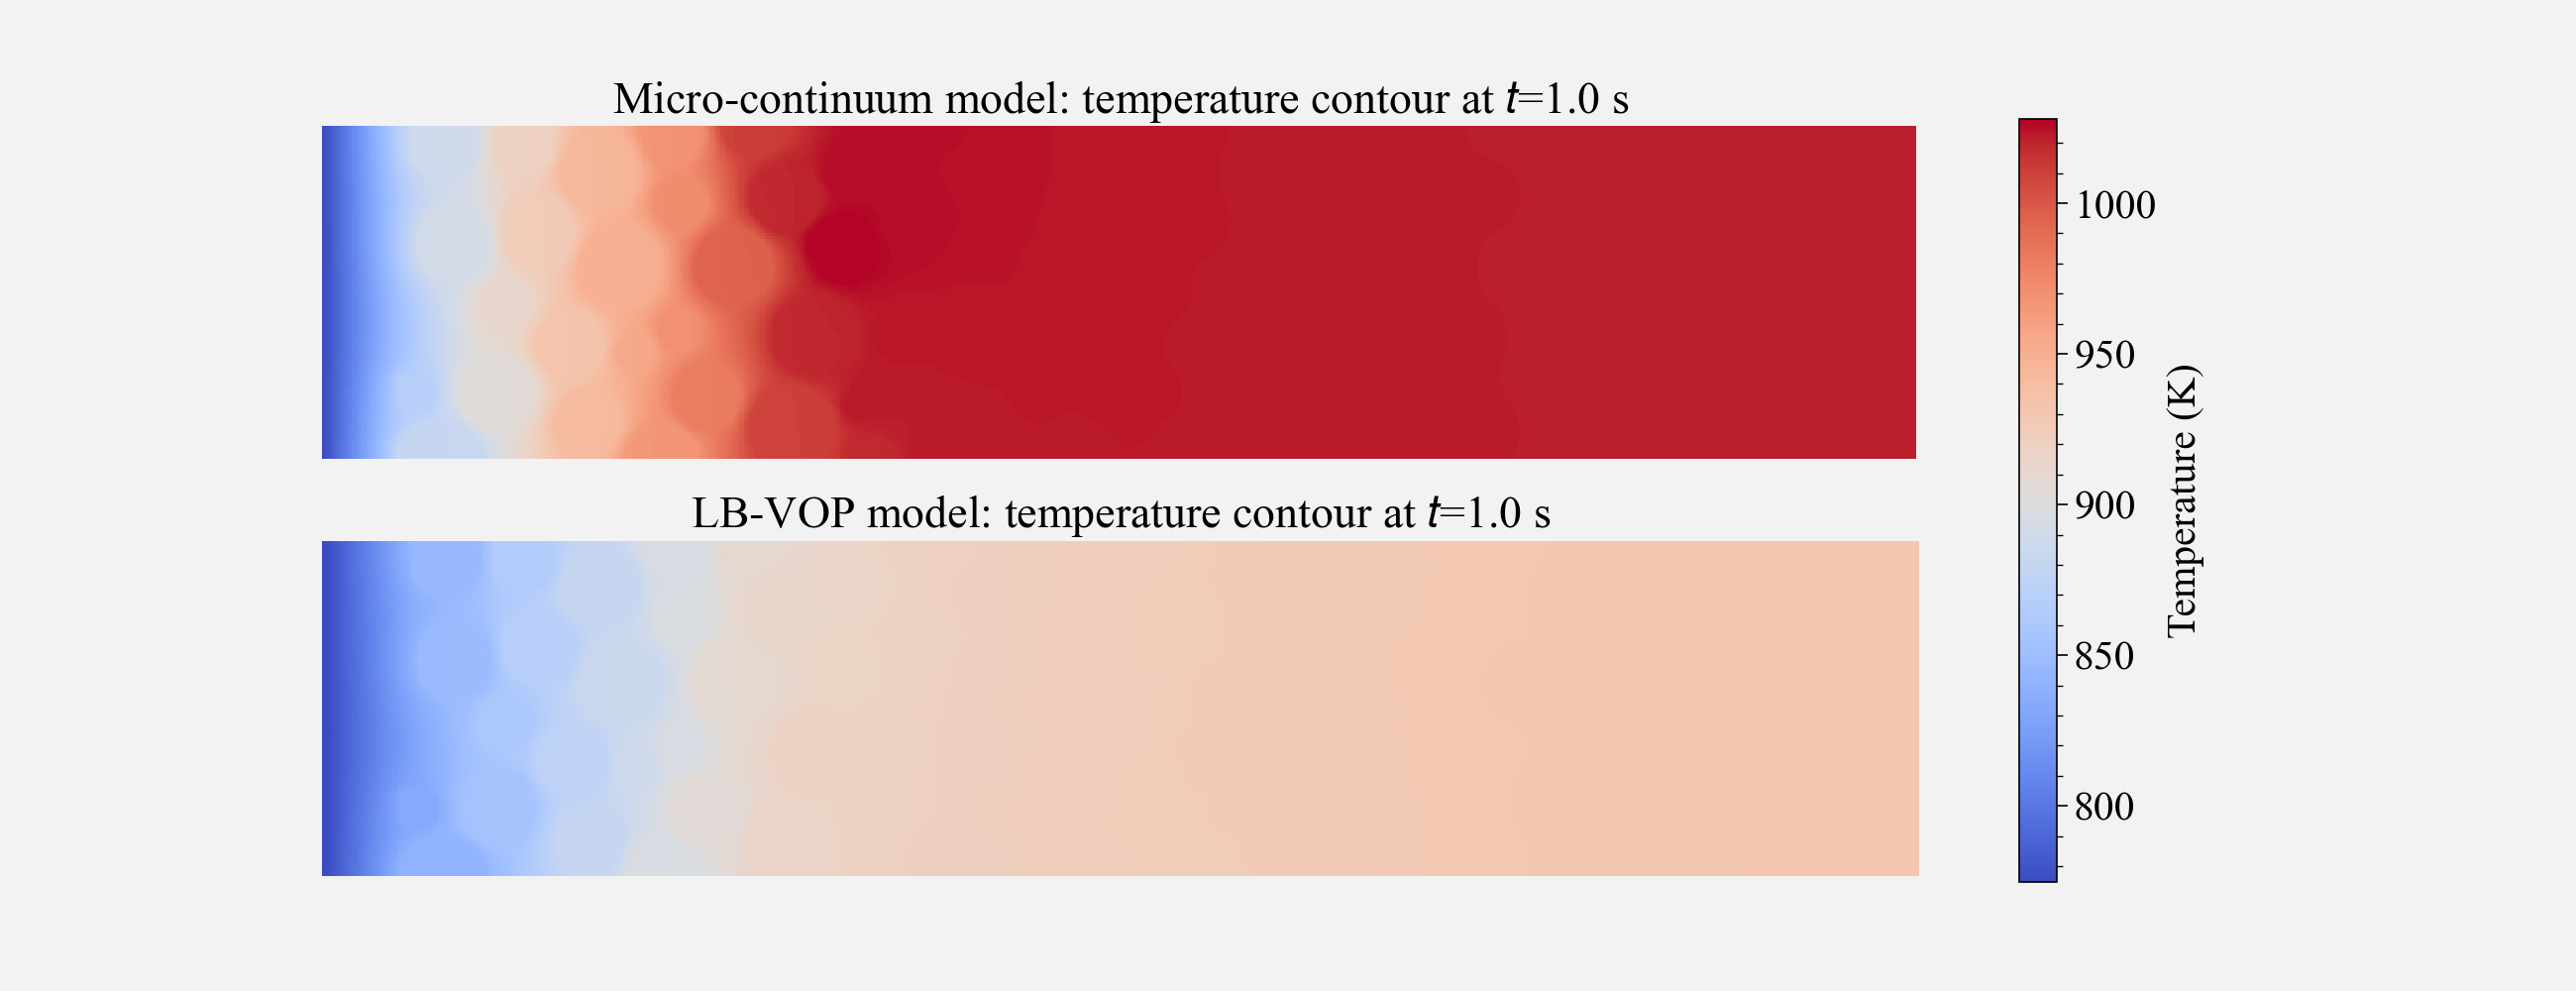

In [30]:

fig,ax=showContour(temperatureFieldDBS_1s*Tref,temperatureFieldLB_1s*Tref,"Micro-continuum model: temperature contour at $\mathit{t}$=1.0 s","LB-VOP model: temperature contour at $\mathit{t}$=1.0 s", label="Temperature (K)")

fig.savefig("comparison of temperature contour at 1s.jpg",bbox_inches='tight',dpi=600)

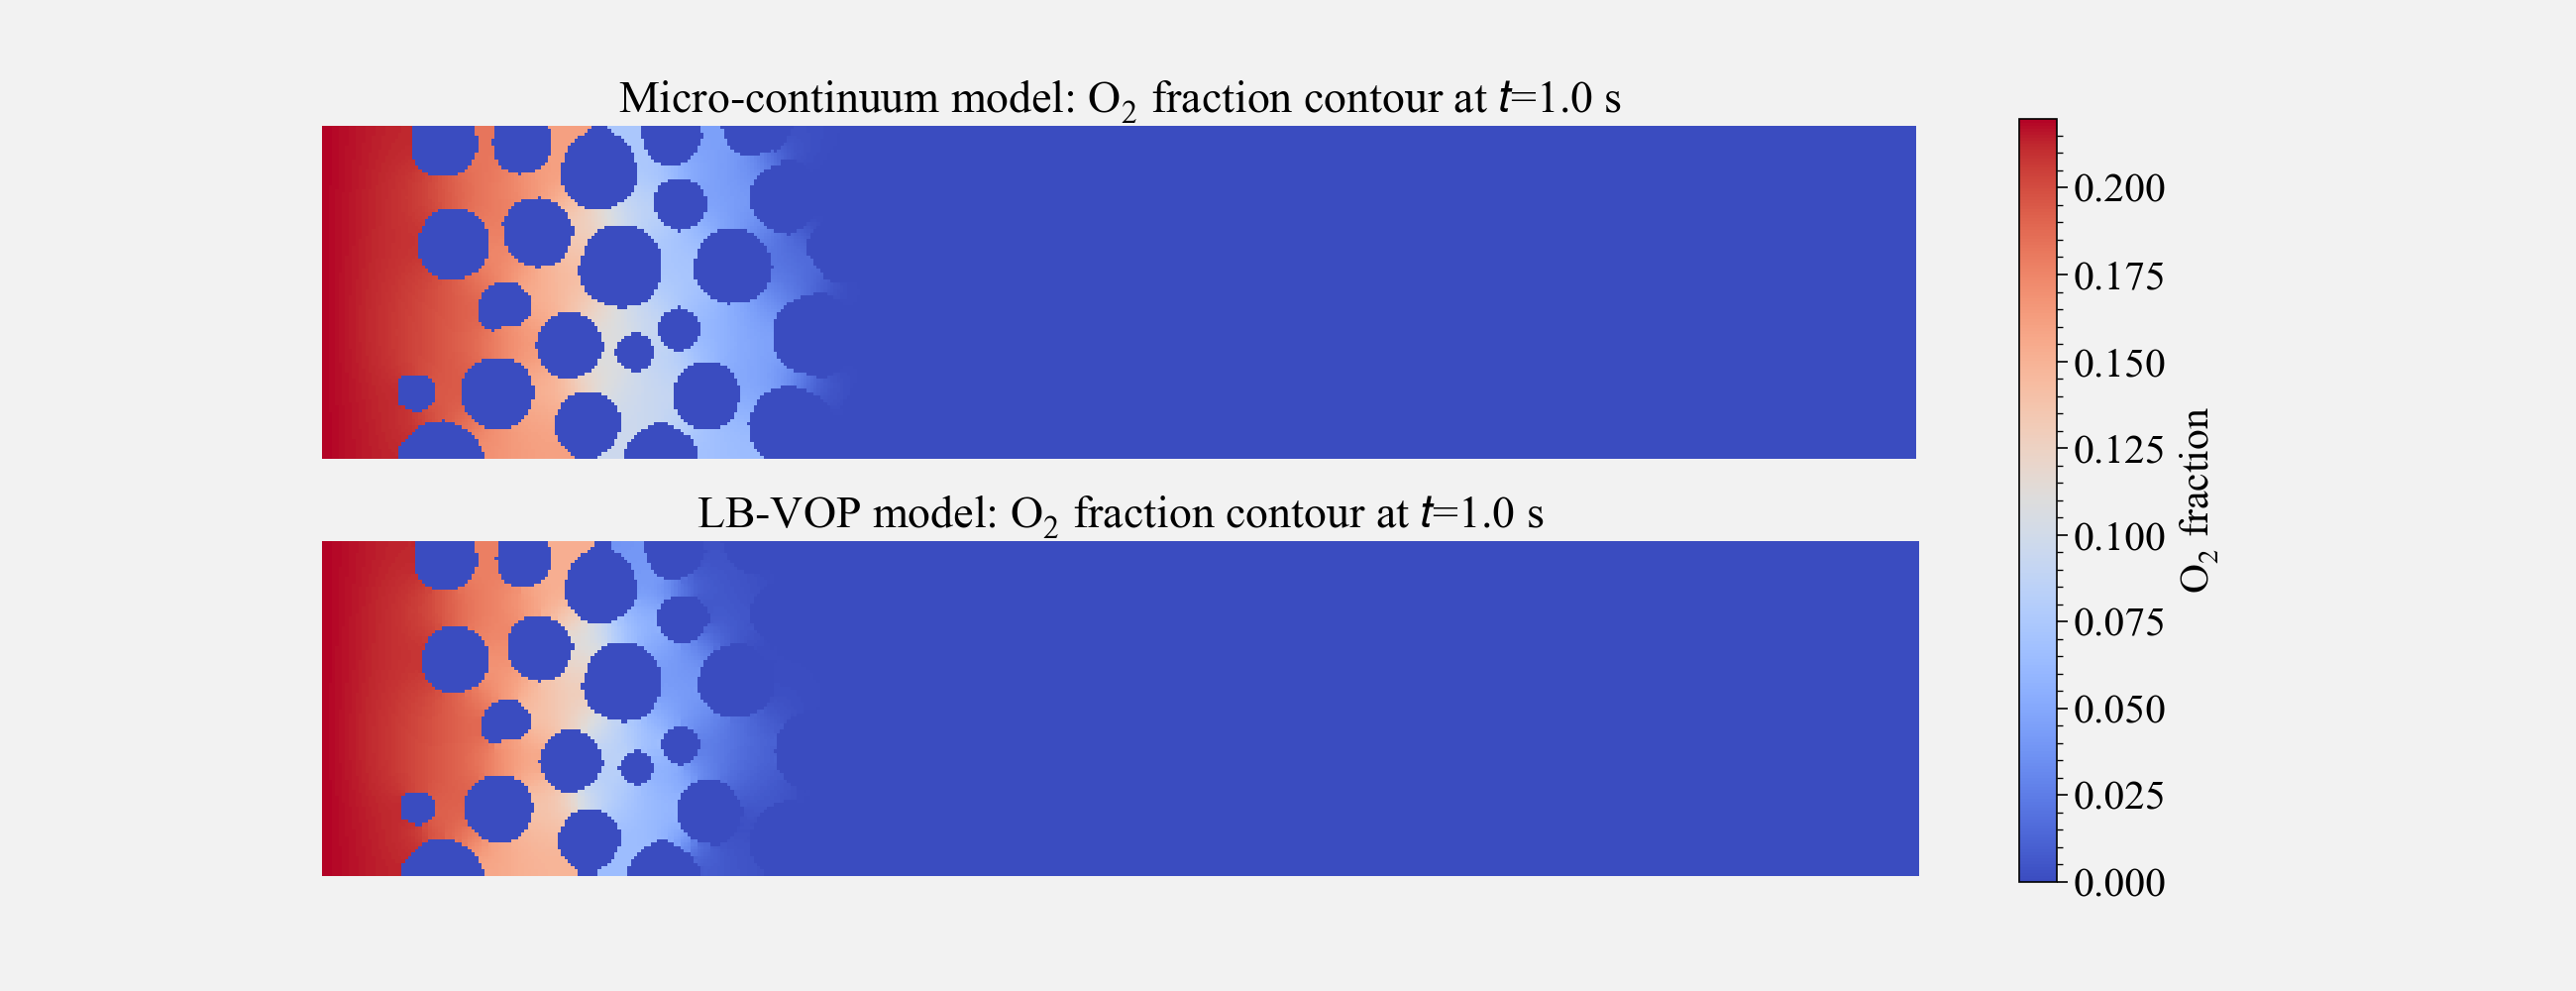

In [31]:


fig,ax=showContour(O2FieldDBS_1s*(1.0-solidFieldDBS_1s),O2FieldLB_1s,"Micro-continuum model: O$_{2}$ fraction contour at $\mathit{t}$=1.0 s","LB-VOP model: O$_{2}$ fraction contour at $\mathit{t}$=1.0 s", label="O$_{2}$ fraction")

fig.savefig("comparison of O2 fraction contour at 1s.jpg",bbox_inches='tight',dpi=600)

